# Preprocessing of in-person data

This notebook loads the CSV created in the previous notebook and performs all the necessary data manipulations to get the data ready for analysis.

## Import Libraries

In [1]:
# Import necessary libraries and modules
import pandas as pd
import numpy as np

# Matplotlib and Seaborn for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

## Load and Preprocess Demographic Data

In [2]:
# load demographic data
age = pd.read_csv('../demo.csv')

## Load and Preprocess Choice Data

In [3]:
# Load choice data
db_mon = pd.read_csv('data/mon.csv')
db_med = pd.read_csv('data/med.csv')

# Print the number of unique participants in each dataset
print('Participants monetary: ', len(db_mon['sub'].unique()), 'participants medical: ', len(db_med['sub'].unique()))

Participants monetary:  98 participants medical:  98


## Identify and Filter Participants

Remove participants who are missing demographic data (usually failed to show for sessions 2 and 3) or choice data.

In [4]:
# Extract unique subject numbers from the 'age' and 'db_mon' dataframes.
s_am = list(age['sub'].unique())  # Subjects from the 'age' dataframe
s_ra = list(db_mon['sub'].unique())  # Subjects from the 'db_mon' dataframe

# Identify subjects who are present in one list but not in the other.
demo_no_ra = list(set(s_am) - set(s_ra))  # Participants in 'age' but not in 'db_mon'
ra_no_demo = list(set(s_ra) - set(s_am))  # Participants in 'db_mon' but not in 'age'

# Print the participants who are in the 'db_mon' dataset but do not have MoCA data.
print('pariticpant with R&A and no MoCA:', ra_no_demo)



pariticpant with R&A and no MoCA: [12, 21, 22, 31, 34, 35, 45, 47, 48, 53, 54, 62, 64, 65, 67, 70, 79, 81, 84, 89, 91, 97, 98, 99, 110, 112, 114]


### Merge and Filter Data

In [5]:
# Filter the 'age' dataframe to only include participants who are also present in the 'db_mon' dataframe.
age = age[age['sub'].isin(db_mon['sub'].values)]

# Merge the demographic data (age, MoCA score, and gender) with the 'db_mon' and 'db_med' datasets.
# This provides a consolidated view where each participant's data from different sources is combined into one row.
db_mon = db_mon.merge(age, left_on='sub', right_on='sub')  # Merge with 'db_mon'
db_med = db_med.merge(age, left_on='sub', right_on='sub')  # Merge with 'db_med'

# Filter participants based on their MoCA score. 
# Only include cognitive healthy participants (MoCA score greater than 25).
db_mon = db_mon[db_mon['moca_score'] > 25]
db_med = db_med[db_med['moca_score'] > 25]

# Print the total number of participants who have all required data (after merging and filtering).
print('Number of participants with all data:', len(db_med['sub'].unique()))

Number of participants with all data: 71


## Identify and Exclude Participants who are Too Risk-Averse 

In [6]:
# Define a threshold for the minimum number of trials in which a participant chose the lottery option.
risk_min = 1

# For each participant in the 'db_mon' and 'db_med' datasets, sum up the number of times they chose the lottery option.
choices_mon = db_mon[['sub', 'choice']].groupby(['sub']).sum()  # For 'db_mon' dataset
choices_med = db_med[['sub', 'choice']].groupby(['sub']).sum()  # For 'db_med' dataset

# Identify participants who chose the lottery less than the threshold (risk_min) and are thus considered too risk-averse.
too_risk_averse_mon = list(choices_mon[choices_mon['choice'] < risk_min].index)  # For 'db_mon' dataset
too_risk_averse_med = list(choices_med[choices_med['choice'] < risk_min].index)  # For 'db_med' dataset

# Print the participants who are too risk-averse for both monetary and medical scenarios.
print('Monetary too risk averse (', risk_min, '): ', too_risk_averse_mon)
print('Medical too risk averse (', risk_min, '): ', too_risk_averse_med)

# Exclude the too risk-averse participants from the 'db_mon' and 'db_med' datasets.
db_mon = db_mon[~db_mon['sub'].isin(too_risk_averse_mon)]
db_med = db_med[~db_med['sub'].isin(too_risk_averse_med)]

# Extract unique participants from the updated 'db_mon' and 'db_med' datasets.
mon_s = list(db_mon['sub'].unique())
med_s = list(db_med['sub'].unique())

# Filter both datasets to only include participants that are present in both.
# This ensures consistency and allows for direct comparisons between the monetary and medical scenarios.
db_mon = db_mon[db_mon['sub'].isin(med_s)]
db_med = db_med[db_med['sub'].isin(mon_s)]

# Print the number of participants retained after the above filters.
print('Subjects who were not too risk averse: ', len(db_mon['sub'].unique()), len(db_med['sub'].unique()))

Monetary too risk averse ( 1 ):  [11, 40]
Medical too risk averse ( 1 ):  []
Subjects who were not too risk averse:  69 69


## Identify and Exclude Participants Failing Attention Checks

In [7]:
# Identify participants in the 'db_mon' and 'db_med' datasets who failed 7 or more catch trials out of 12.
mon_catch = db_mon[db_mon.catch >= 7]  # For 'db_mon' dataset
med_catch = db_med[db_med.catch >= 7]  # For 'db_med' dataset

# Extract the unique participant identifiers for those who failed catch trials in both datasets.
mon_catch_n = mon_catch['sub'].unique()  # For 'db_mon' dataset
med_catch_n = med_catch['sub'].unique()  # For 'db_med' dataset

# Print the participants who failed catch trials in both monetary and medical scenarios.
print('Subjects who failed catch trials: mon:', mon_catch_n, '; med:', med_catch_n)

# Exclude participants from both datasets who failed 7 or more catch trials out of 12.
db_med = db_med[db_med.catch < 7]
db_mon = db_mon[db_mon.catch < 7]

# Extract unique participants from the updated 'db_mon' and 'db_med' datasets.
mon_s = list(db_mon['sub'].unique())
med_s = list(db_med['sub'].unique())

# Filter both datasets to only include participants that are present in both.
# This step ensures that participants who failed the catch trials in one scenario but not in the other are excluded from both.
db_mon = db_mon[db_mon['sub'].isin(med_s)]
db_med = db_med[db_med['sub'].isin(mon_s)]

# Print the number of participants retained after excluding those who failed the catch trials.
print('Subjects who didn not fail attention check: ', len(db_mon['sub'].unique()), len(db_med['sub'].unique()))

Subjects who failed catch trials: mon: [ 17  27 111] ; med: [111]
Subjects who didn not fail attention check:  66 66


## Data Cleaning and Transformation

In [8]:
# For the 'db_med' dataset:

# Remove rows with missing data.
db_med = db_med.dropna()

# Convert the 'choice' column to integer data type.
db_med['choice'] = db_med['choice'].astype('int')

# Sort the dataset based on the 'sub' (subject) column for easier comparison in later analyses.
db_med = db_med.sort_values('sub').reset_index(drop=True)

# Assign a unique serial number for each participant. This will be useful for indexing operations.
db_med['subn'] = db_med['sub'].rank(method='dense').astype(int) - 1

# Count the number of unique subjects in the 'db_med' dataset.
n_subs_med = db_med['subn'].unique().shape[0]

# Create a list of subject indices for all rows in the 'db_med' dataset.
sub_idx_med = db_med.subn.tolist()

# Print the final number of subjects and trials in the 'db_med' dataset.
print("Final sample Medical includes {} subjects and {} valid trials".format(n_subs_med, len(sub_idx_med)))


# For the 'db_mon' dataset (similar processing as for 'db_med'):

# Remove rows with missing data.
db_mon = db_mon.dropna()

# Convert the 'choice' column to integer data type.
db_mon['choice'] = db_mon['choice'].astype('int')

# Sort the dataset based on the 'sub' (subject) column for easier comparison in later analyses.
db_mon = db_mon.sort_values('sub').reset_index(drop=True)

# Assign a unique serial number for each participant.
db_mon['subn'] = db_mon['sub'].rank(method='dense').astype(int) - 1

# Count the number of unique subjects in the 'db_mon' dataset.
n_subs = db_mon['subn'].unique().shape[0]

# Create a list of subject indices for all rows in the 'db_mon' dataset.
sub_idx = db_mon.subn.tolist()

# Print the final number of subjects and trials in the 'db_mon' dataset.
print("Final sample Monetary includes {} subjects and {} valid trials".format(n_subs, len(sub_idx)))

Final sample Medical includes 66 subjects and 5501 valid trials
Final sample Monetary includes 66 subjects and 5518 valid trials


## Create Dummy Variables

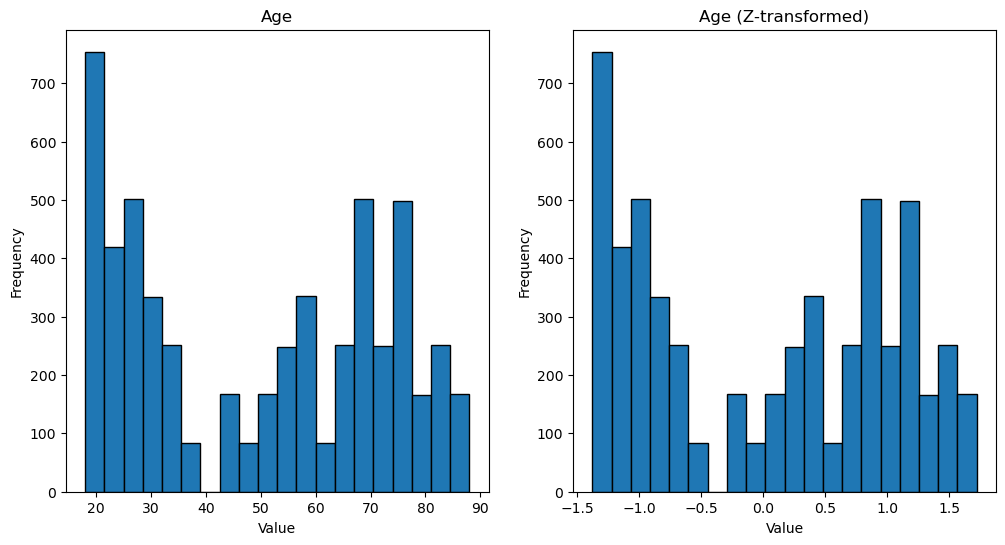

In [9]:
# For the 'db_med' dataset:

# Create a new column 'level' in the 'db_med' dataset by ranking the 'value' column using the dense method.
db_med['level'] = db_med['value'].rank(method='dense').astype(int)

# Create dummy variables (indicators) for each level by comparing 'level' to thresholds from 0 to 3.
db_med['l1'] = db_med.level > 0
db_med['l2'] = db_med.level > 1
db_med['l3'] = db_med.level > 2
db_med['l4'] = db_med.level > 3

# Convert the boolean dummy variables to integers (0 or 1).
db_med['l1'] = db_med['l1'].astype(int)
db_med['l2'] = db_med['l2'].astype(int)
db_med['l3'] = db_med['l3'].astype(int)
db_med['l4'] = db_med['l4'].astype(int)

# For the 'db_mon' dataset:

# Rank the 'value' column in the 'db_mon' dataset.
db_mon['level'] = db_mon['value'].rank(method='dense').astype(int)

# Create dummy variables for each level in the 'db_mon' dataset.
db_mon['l1'] = db_mon.level > 0
db_mon['l2'] = db_mon.level > 1
db_mon['l3'] = db_mon.level > 2
db_mon['l4'] = db_mon.level > 3

# Convert boolean indicators to integers.
db_mon['l1'] = db_mon['l1'].astype(int)
db_mon['l2'] = db_mon['l2'].astype(int)
db_mon['l3'] = db_mon['l3'].astype(int)
db_mon['l4'] = db_mon['l4'].astype(int)

# Z-transform the 'age' variable for both datasets to have a mean of 0 and a standard deviation of 1. 
db_mon['ageZ'] = (db_mon['age'] - db_mon['age'].mean()) / db_mon['age'].std()
db_med['ageZ'] = (db_med['age'] - db_med['age'].mean()) / db_med['age'].std()

# Create a subplot layout with 1 row and 2 columns.
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the original 'age' histogram for the 'db_mon' dataset on the first subplot.
axes[0].hist(db_mon['age'], bins=20, edgecolor='black')
axes[0].set_title('Age')
axes[0].set_xlabel('Value')
axes[0].set_ylabel('Frequency')

# Plot the Z-transformed 'ageZ' histogram for the 'db_mon' dataset on the second subplot.
axes[1].hist(db_mon['ageZ'], bins=20, edgecolor='black')
axes[1].set_title('Age (Z-transformed)')
axes[1].set_xlabel('Value')
axes[1].set_ylabel('Frequency')

# Display the created plots.
plt.show()


Total: 66 
Females:  30


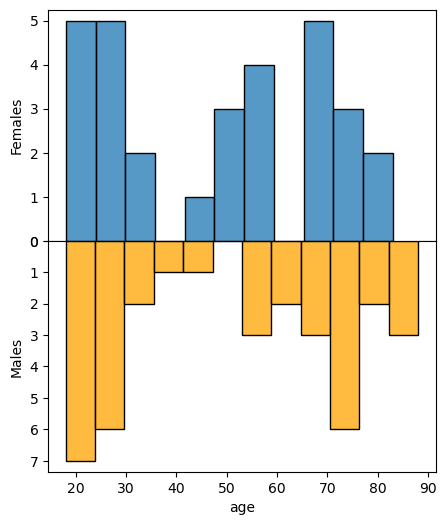

In [10]:
# Drop duplicates based on the 'sub' (subject) column to get unique participants
participants = db_mon.drop_duplicates(['sub'])

# Create a subplot layout with 2 rows and 1 column.
fig, ax = plt.subplots(2, 1, figsize=(5, 6), sharex=True)

# On the first subplot (top), plot the age distribution for female participants
sns.histplot(participants[participants['gender'] == 'F']['age'], binwidth=6, ax=ax[0])

# On the second subplot (bottom), plot the age distribution for male participants using an orange color
sns.histplot(participants[participants['gender'] == 'M']['age'], binwidth=6, color='orange', ax=ax[1])

# Set the y-labels for both subplots to denote the gender, and only set an x-label for the bottom plot
ax[0].set(ylabel='Females', xlabel='')
ax[1].set(ylabel='Males')

# Invert the y-axis for the male age distribution to have the histogram bars grow upwards 
# (this makes it visually comparable with the female age distribution)
ax[1].invert_yaxis()

# Adjust the space between subplots to make them touch (removing any gap)
plt.subplots_adjust(wspace=0, hspace=0)

# Print out the total number of unique participants and the number of female participants
print("Total:", participants.shape[0], "\nFemales: ", participants[participants['gender'] == 'F'].shape[0])

## Save Cleaned Data

In [11]:
db_mon.to_csv('data/mon_clean.csv')
db_med.to_csv('data/med_clean.csv')

In [12]:
%load_ext watermark
%watermark -n -u -v -iv -w -p xarray

Last updated: Mon Aug 05 2024

Python implementation: CPython
Python version       : 3.10.14
IPython version      : 8.26.0

xarray: 2024.7.0

matplotlib: 3.9.1
pandas    : 2.2.2
seaborn   : 0.13.2
numpy     : 1.23.5

Watermark: 2.4.3

